In [1]:
!pwd

/Users/touchpadthamkul/zatoDev/project/bads_crm_final/master/BADS7105/writing


In [1]:
PROJECT_LINK = 'assignment3'
PATH = '/Users/touchpadthamkul/zatoDev/project/bads_crm_final/master/BADS7105'


# FRAMEWORK
from IPython.display import Markdown as md
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import datetime, pytz
import numpy as np
import os

pio.renderers.default = 'colab'

def getVariableNames(variable):
    results = []
    globalVariables=globals().copy()
    for globalVariable in globalVariables:
        if id(variable) == id(globalVariables[globalVariable]):
            results.append(globalVariable)
    return results

def displayPlot(fig):
    project_id = PROJECT_LINK.replace(' ','_')
    fig_json = fig.to_json()
    fig_name = str(datetime.datetime.now(tz=pytz.timezone('Asia/Bangkok')).date())+'-'+project_id+'_'+getVariableNames(fig)[0]
    filename = fig_name+'.html'
    if PATH != '':
        save_path = PATH + '/_includes/post-figures/'
    else:
        save_path = ''
    completeName = os.path.join(save_path, filename)
    template = """
<html>
    <head>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    </head>
    <body>
        <div id='{1}'></div>
        <script>
            var plotly_data = {0};
            let config = {{displayModeBar: false }};
            Plotly.react('{1}', plotly_data.data, plotly_data.layout, config);
        </script>
    </body>
</html>
"""
    # write the JSON to the HTML template
    with open(completeName, 'w') as f:
        f.write(template.format(fig_json, fig_name))
    return md("{% include post-figures/" + filename + " full_width=true %}")

def displayImg(img_name):
    master_name = str(datetime.datetime.now(tz=pytz.timezone('Asia/Bangkok')).date()) + '-' + PROJECT_LINK + '-' + img_name
    !cp -frp $img_name $master_name
    if PATH != '':     
        img_path = PATH + '/images/projects'
        !mv $master_name $img_path
        output = md("![](/BADS7105/images/projects/" + master_name +")")
    else:
        img_path = PATH
        output = md("![]("+master_name +")")
    return output

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

def runBrowser(url):
    url = 'https://zato.dev/blog/' + PROJECT_LINK
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("window-size=375,812")
    # browser = webdriver.Chrome('/Users/touchpadthamkul/PySelenium/chromedriver', chrome_options=chrome_options)
    browser = webdriver.Chrome(ChromeDriverManager().install(),chrome_options=chrome_options)
    browser.get(url)

    
import ipynbname

def saveExport():        
    pynb_name = ipynbname.name() +'.ipynb'
    md_name = ipynbname.name() +'.md'
    if PATH != '':
        selected = int(input('1 posts \n2 projects\n'))
        if selected != 1:
            folder = '/_projects'
        else:
            folder = '/_posts'
        post_path = PATH + folder
    else:
        post_path = ''
    master_name = str(datetime.datetime.now(tz=pytz.timezone('Asia/Bangkok')).date()) + '-' + PROJECT_LINK + '.md'
    !jupyter nbconvert --to markdown $pynb_name
    !mv $md_name $master_name
    !mv $master_name $post_path

# saveExport()
# runBrowser(url)

##  Objective

จากโจทย์วันนี้ อาจารย์ให้เพื่อนทุกคนส่งแบบสอบถามว่าเคย/ไ่ม่เคยซื้อสินค้า เพื่อนำมาศึกษาด้วย Market Basket Analysis หรือ Collaborative Filtering และทดลองแนะนำสินค้า ด้วยสินค้าที่เพื่อนนิยมซื้อไปด้วยกันมากที่สุด

เริ่มจากดึงข้อมูลแบบสอบถามจากเพื่อนในห้อง ข้อมูลทั้งหมด 47 แถว และมีสินค้าทั้งหมด 41 ชิ้น

In [10]:
import pandas as pd
raw_df = pd.read_csv("cross_selling.csv")
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Timestamp                      47 non-null     object
 1   playstation5                   46 non-null     object
 2   เครื่องทำขนมปัง                46 non-null     object
 3   Ergonomic Wrist Rest           46 non-null     object
 4   เครื่องอบผ้า                   46 non-null     object
 5   เครื่องชงกาแฟแคปซูล            46 non-null     object
 6   เก้าอี้ LA-Z-Boy               46 non-null     object
 7   เครื่องให้อาหารสัตว์อัตโนมัติ  46 non-null     object
 8   บัตตาเลี่ยน                    45 non-null     object
 9   แก้วเก็บความเย็น               46 non-null     object
 10  ลู่วิ่งออกกำลังกาย             46 non-null     object
 11  Kindle                         46 non-null     object
 12  เครื่องซักผ้า                  46 non-null     object
 13  Bluetoo

เตรียมข้อมูลสำหรับ Collaborative Filtering ทำการ Clean ข้อมูล เคยซื้อ-ไม่เคยซื้อ และรวมไว้ในคอลัมน์ Transaction และ Item

In [13]:
pre_df = raw_df.reset_index().rename(columns={"index": "Transaction"}).drop(columns="Timestamp").dropna()
df1 = pd.melt(pre_df, id_vars=['Transaction'], value_vars=pre_df.columns.tolist()[1:]).rename(columns={'variable': 'Item'})
df = df1[~df1["value"].str.contains("ไม่")].sort_values("Transaction").drop(columns="value").reset_index(drop=True)
df.loc[df["Item"]=='NONE'].shape[0]
df = df[df["Item"] != 'NONE']
df

,Transaction,Item
0,1,การ์ดจอ RTX 3080
1,1,บัตตาเลี่ยน
2,1,หม้อทอดไร้น้ํามัน
3,1,Deskmat
4,1,Mechanical keyboard
...,...,...
457,46,ยาดม
458,46,Bluetooth Speaker
459,46,airpods
460,46,Mechanical keyboard


ทำ One Hot Encoding เพื่อรวม Transaction และทำให้ข้อมูลอยู่ในรูปแบบ Binary 

In [16]:
hot_encoded_df=df.groupby(['Transaction','Item'])['Item'].count().unstack().reset_index().fillna(0).set_index('Transaction')
hot_encoded_df = hot_encoded_df.applymap(encode_units)
hot_encoded_df.head(5)

Item,Bluetooth Speaker,Deskmat,Dew - ไฟโรเซ่,Ergonomic Wrist Rest,External Harddisk,Kindle,Logitech Mx Master 3 Mouse,Mechanical keyboard,Nintendo switch,PS5,...,เก้าอี้ LA-Z-Boy,เครื่องชงกาแฟแคปซูล,เครื่องซักผ้า,เครื่องทำขนมปัง,เครื่องอบผ้า,เครื่องให้อาหารสัตว์อัตโนมัติ,เทียนหอม jo malone,แก้วเก็บความเย็น,ไฟส่องหน้าไลฟ์สด,ไฟแต่งห้องมินิมอล
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,1,0,0,0,1,0,0,1,0,0,...,0,1,1,0,1,0,1,1,1,1
4,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1,0,0,0,1,0,0,0,0,0,...,1,0,1,0,1,0,1,1,0,0


ใช้ฟังก์ชัน association_rules จาก Library mlxtend

In [18]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(hot_encoded_df, min_support=0.6, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values("support", ascending=False).reset_index(drop=True).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Salmon Sashimi),(ยาดม),0.825,0.825,0.725,0.878788,1.065197,0.044375,1.443750
1,(ยาดม),(Salmon Sashimi),0.825,0.825,0.725,0.878788,1.065197,0.044375,1.443750
2,(ยาดม),(Bluetooth Speaker),0.825,0.700,0.625,0.757576,1.082251,0.047500,1.237500
3,(Bluetooth Speaker),(ยาดม),0.700,0.825,0.625,0.892857,1.082251,0.047500,1.633333
4,(แก้วเก็บความเย็น),(ยาดม),0.750,0.825,0.625,0.833333,1.010101,0.006250,1.050000


In [ ]:
## สรุป

สินค้าที่ควรแนะนำให้ลูกค้าคือ
1. ยาดม และ Bluetooth Speakere
2. ยาดม และ Salmon Sashimi
3. ยาแด

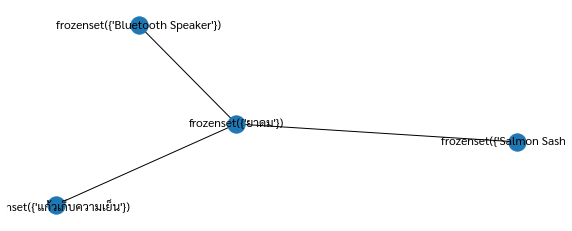

In [45]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

mpl.font_manager.fontManager.addfont('Sarabun-Regular.ttf')
mpl.rc('font', family='Sarabun')
fig, ax=plt.subplots(figsize=(10,4))
GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True, font_family="Sarabun")
plt.show()